In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#parameters
in_file = '../../merge/Ulz_results_merged.txt'
out_dir = 'Ulz_results'
metadata_file = '../../../../../metadata/MBC/merged_key_metadata.txt'
status_col = 'merged_updated_ER_status_binary'
n_iter = 1000

In [3]:
#get data
data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data = data[(data['merged_updated_ER_status_binary']=='+') | (data['merged_updated_ER_status_binary']=='-')]
data['status'] = np.where(data['merged_updated_ER_status_binary']=='+',1,0)

features = data.drop(columns = ['status','merged_updated_ER_status_binary','tumor_fraction']).columns
print('features:',len(features))

data = data[features]

#get metadata
metadata = pd.read_csv(metadata_file, sep='\t')
metadata = metadata.set_index('sample')
data = data.merge(metadata, left_index=True, right_index=True)
data['status'] = np.where(data[status_col]=='+',1,0)

#filter data
min_tfx = 0.05

#training data
data = data[(data['tumor_fraction']>=min_tfx)]
print('total',len(data))
print(data[status_col].value_counts())

high_tfx = data[(data['tumor_fraction']>=0.1)]
print('high tfx',len(high_tfx))
print(high_tfx[status_col].value_counts())
del(high_tfx)

data = data.sort_index()

features: 504
total 254
+    132
-    122
Name: merged_updated_ER_status_binary, dtype: int64
high tfx 191
+    99
-    92
Name: merged_updated_ER_status_binary, dtype: int64


In [4]:
data.head()

,ADNP,AEBP2,AhR,Androgen,AP-2&#945;,AP-2&#947;,AP-4,ARID1A,ARID1B,ARID2,...,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,status
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1041_1_ULP,0.663000,0.559979,0.524956,0.435470,0.564123,0.457874,0.473241,0.498999,0.471538,0.625376,...,same,+,+,-,+,gain,6746.0,1.0,1.0,1
MBC_1041_3_ULP,0.595825,0.731607,0.567691,0.556422,0.492288,0.542550,0.679235,0.531885,0.514633,0.706758,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1041_4_ULP,0.355225,0.469595,0.482412,0.573310,0.421278,0.529004,0.548445,0.551574,0.473019,0.668203,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1042_1_ULP,0.553555,0.827097,0.667771,0.745176,0.755112,0.660230,0.802675,0.925846,0.836484,0.831596,...,same,+,+,+,-,loss,2116.0,1.0,NaN,1
MBC_1042_2_ULP,0.541721,1.488499,0.418453,0.365992,0.587738,0.529618,0.478098,0.598387,0.755463,0.488116,...,same,+,+,+,-,loss,2116.0,1.0,1.0,1


In [5]:
#view data
data.head()

,ADNP,AEBP2,AhR,Androgen,AP-2&#945;,AP-2&#947;,AP-4,ARID1A,ARID1B,ARID2,...,merged_ER_switch,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,status
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1041_1_ULP,0.663000,0.559979,0.524956,0.435470,0.564123,0.457874,0.473241,0.498999,0.471538,0.625376,...,same,+,+,-,+,gain,6746.0,1.0,1.0,1
MBC_1041_3_ULP,0.595825,0.731607,0.567691,0.556422,0.492288,0.542550,0.679235,0.531885,0.514633,0.706758,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1041_4_ULP,0.355225,0.469595,0.482412,0.573310,0.421278,0.529004,0.548445,0.551574,0.473019,0.668203,...,same,+,+,-,+,gain,6746.0,1.0,NaN,1
MBC_1042_1_ULP,0.553555,0.827097,0.667771,0.745176,0.755112,0.660230,0.802675,0.925846,0.836484,0.831596,...,same,+,+,+,-,loss,2116.0,1.0,NaN,1
MBC_1042_2_ULP,0.541721,1.488499,0.418453,0.365992,0.587738,0.529618,0.478098,0.598387,0.755463,0.488116,...,same,+,+,+,-,loss,2116.0,1.0,1.0,1


In [6]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

ADNP         -1.146939e-15
AEBP2        -1.328771e-16
AhR          -2.727477e-16
Androgen      2.692509e-16
AP-2&#945;    2.447736e-16
                  ...     
ZSCAN22       5.419986e-16
ZSCAN2        1.538577e-16
ZSCAN5A      -6.434048e-16
ZSCAN5D      -1.678447e-16
ZXDC         -9.790943e-17
Length: 504, dtype: float64

In [7]:
#bootstrapping
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

#loop for each iteration
countup = 0
for i in range(n_iter):
    if i%50==0:
        print(i,countup, time.time()-start_time)
    
    patients = pd.Series(data['patient_id'].unique())
    
    good_split = 0
    while good_split == 0:
        #bootstrap a training set with replacement
        training_ids = patients.sample(len(patients), replace = True, random_state = 100+countup)
                
        #get bootstrapped training set, if a patient ID is included in the training_ids set j times, include all samples from that patient j times
        training = pd.DataFrame()
        
        #group the training patient IDs by number of times they are observed in the bootstrapped training_ids
        for j,df in pd.DataFrame(training_ids.value_counts().rename('count')).groupby(by = 'count'):

            #identify the samples from this group of patients
            current_data = data[data['patient_id'].isin(df.index)]

            #copy the training samples so that they appear j times in training dataframe
            current_training = pd.DataFrame()
            for k in range(j):
                current_training = current_training.append(current_data)
            training = training.append(current_training)
        
        
        #the test set is all samples that aren't seen in the training data
        test = data[~(data.index.isin(training.index))]
        
        #check to make sure first time point low tumor fraction samples for both classes are included in the test set
        if len(test[(test['tumor_fraction']<.1) & (test['first_passing_sample']==1)]['status'].unique())!=2:
            print('skipping iteration',i)
            countup += 1
        else:
            good_split = 1
    
    #countup will get ahead of i if it has to skip bad train-test splits
    countup +=1
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state =100+countup) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    current_output['prediction']=pred
    current_output['accuracy'] = np.where(current_output['prediction']==current_output['status'],1,0)    
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)
    

probabilities = probabilities.merge(data[['status']], left_index=True, right_index=True)

0 0 0.0016758441925048828
50 50 45.058103799819946
100 100 87.69942593574524
150 150 131.33220601081848
200 200 176.63792181015015
250 250 221.12343883514404
300 300 265.2335669994354
350 350 310.1989448070526
400 400 354.44070315361023
450 450 399.54044103622437
500 500 444.28945899009705
550 550 488.8062219619751
600 600 535.4512448310852
650 650 582.0936379432678
700 700 625.6333239078522
skipping iteration 715
750 751 669.0513281822205
800 801 712.9812240600586
850 851 759.6419968605042
900 901 804.2274899482727
950 951 848.2722089290619


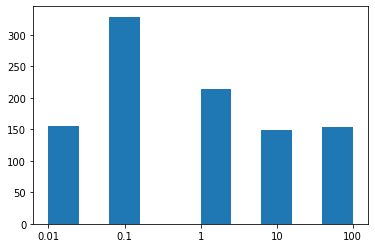

In [8]:
#export results
probabilities.to_csv(out_dir+'/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(out_dir+'/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(out_dir+'/coefs.txt', sep='\t')

plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(out_dir+'/cvals.pdf')

In [9]:
#print key info

In [10]:
probabilities = probabilities.merge(data[['first_passing_sample','tumor_fraction']], left_index=True, right_index=True)

In [11]:
#high tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.5424621803268842

In [12]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']>=0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.5431460433664723

In [13]:
#low tfx per patient accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1) & (current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.5580764188633266

In [14]:
#per sample accuracy
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status','tumor_fraction','first_passing_sample']]
    current = current[(current['tumor_fraction']<0.1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
np.mean(accuracy)

0.5533631872182814

In [15]:
#per patient accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'first_passing_sample','status']]
    current = current[(current['first_passing_sample']==1)]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.546532843247456

In [16]:
#per sample accuracy for all samples
accuracy = []
for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][[i,'status']]
    accuracy.append(sum(np.round(current[i])==current['status'])/len(current))
    
np.mean(accuracy)

0.5466598832258348